In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
from numba import jit, prange
import scipy.optimize as opt


import tables
import os

test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''

63734


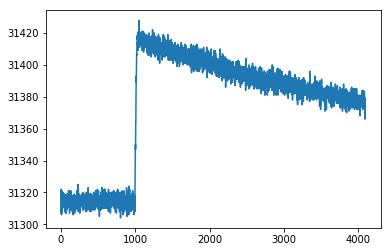

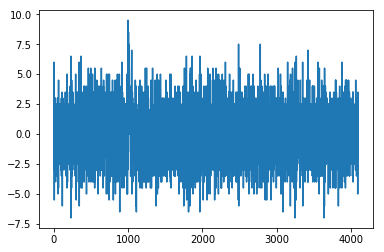

In [19]:
h5file = tables.open_file("test_input.h5", driver="H5FD_CORE")
print(h5file)
data = h5file.root.RawData
EventData = h5file.root.EventData
print(len(EventData))



plt.figure()
plt.plot(data[100,:])
plt.figure()
plt.plot(np.gradient(data[100,:]))
plt.show()

In [20]:
# Find pulses that triggered multiple times and delete them
i_pileup = 0
j_pileup = 0
pileup_args = np.array([])
EventDataArray = np.array(EventData)

for x in range(len(EventData)):
    if int(EventData[x][3])>1:
        pileup_args = np.append(pileup_args,i_pileup)
        j_pileup = j_pileup+1  
    i_pileup = i_pileup+1

print(data)
print(len(pileup_args))

data = np.delete(data[:], pileup_args, 0)
    
print('deleted ', len(pileup_args),' signals due to pile up')
#print(len(data2))

/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''
1248


/Users/DragonKnight/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


deleted  1248  signals due to pile up


In [21]:
@jit(parallel = True)
def baseLineReduction(mysignal):
    avgNoise = np.mean(mysignal[0:1000])
    return mysignal-avgNoise

In [22]:
@jit(parallel = True)
def TrapFilter(mysignal,tau):
#    GradSignal = np.gradient(mysignal)
#    argPeak = np.argmax(GradSignal)
#    avgNoise = np.mean(mysignal[0:1000])
    signalOnly = baseLineReduction(mysignal) 
#    
#    @jit(parallel = True)
#    def func(x, a, b):
#        return a * np.exp(-b * x)
#
#    popt, pcov = curve_fit(func, range(0,len(newSignal)-argPeak), newSignal[argPeak:])
#    tau = 1/popt[1]
    
    #signalOnly = newSignal[argPeak:]
#    signalOnly = newSignal
    m=32
    #k=int((len(signalOnly)-m)/2)
    #k = peaking time
    #m= Gap time (in samples)
    k=200
    M = tau
    Acc1=0.0
    Acc2=0.0
#    l =2*k+m
#    final = list(range(len(signalOnly)))
    i=0
    zeros = np.zeros(2*k+m)
    extSignalOnly=np.append(zeros,signalOnly)
    final = np.zeros(len(signalOnly))
    for i in range(len(signalOnly)):
        parta = extSignalOnly[i+(2*k+m)] - extSignalOnly[i-k+(2*k+m)]
        partb = extSignalOnly[i-2*k-m+(2*k+m)] - extSignalOnly[i-k-m+(2*k+m)]
        partc = parta + partb
        Acc1 = Acc1+partc
        partd = partc*M+Acc1
        Acc2 = Acc2 + partd
        final[i] = Acc2
        i=i+1
    
    normFinal = np.array(final)
    #/max(final)
    return normFinal

In [23]:
rows = len(data[:,0])
print(rows)
cols = len(data[0,:])
mysignals = np.zeros((rows,cols))

@jit(parallel = True)
def makesignals(raw_data):
    for j in range(0,rows):
        mysignals[j] = data[j,:]
    return mysignals

startTime = datetime.now()

mysignals = makesignals(data)

print(datetime.now() - startTime)

62486
0:00:04.410252


In [24]:
@jit(parallel = True)
def func(x, a, b):
    return a * np.exp(-b * x)

In [25]:

#tau = np.zeros(events)
#trap_out = np.zeros((events,cols))

@jit(parallel = True)
def eventsProcess(mysignals, events, cols):
#    tau = np.zeros(events)
    startTime = datetime.now()
    trap_out = np.zeros((events,cols))
    for j in range(0,events):
#        print(j)
#        mysignal = mysignals[j,:]
#        GradSignal = np.gradient(mysignal)
#        argPeak = np.argmax(GradSignal)
#        avgNoise = np.mean(mysignal[0:900])
#        newSignal = mysignal - avgNoise
    #    plt.figure()
    #    plt.plot(newSignal)

#        @jit(parallel = True)
#        def func(x, a, b):
#            return a * np.exp(-b * x)

#        popt, pcov = curve_fit(func, range(0,len(newSignal)-1050), newSignal[1050:])
    #    print(popt)
#        tau[j] = 1.0/popt[1]
        trap_out[j] = TrapFilter(mysignals[j,:],5810.8)
#    print('Average Tau across all signals',np.mean(tau))
    print(datetime.now() - startTime)
    return trap_out

In [26]:
print(len(mysignals))
events = len(mysignals)
trap_out = eventsProcess(mysignals, events, cols)

62486
0:00:22.548747


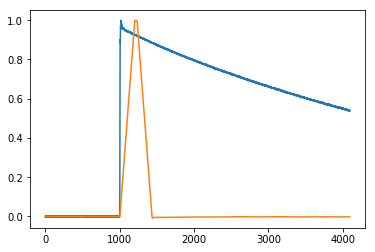

In [27]:
plt.figure()
a_signal = baseLineReduction(mysignals[10][:])
plt.plot(a_signal[:]/np.amax(a_signal))
plt.plot(trap_out[10][:]/np.amax(trap_out[10][:]))
#print(len(trap_out[0]))
#print(np.argmax(trap_out[100][:]))

In [28]:
#from scipy.interpolate import UnivariateSpline
#spline = UnivariateSpline(trap_out[100][:])

In [29]:
#print(len(trap_out[100]))
#print(FWHM(trap_out[100][:],range(len(trap_out[100]))))

In [30]:
counts = []
for j in range(0,len(trap_out)):
    counts = np.append(counts,np.amax(trap_out[j]))

<BarContainer object of 8196 artists>

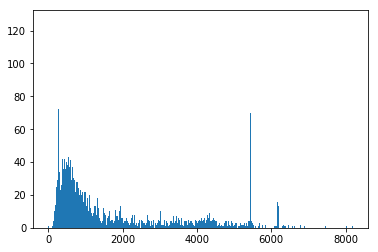

In [31]:
#print(np.trim_zeros(counts))
k=200.0
M = 5810.8
counts2 = np.trim_zeros(counts)
counts2 = counts2/((M+1)*k)
counts3 = counts2[(counts2>0) & (counts2<1e3)]
#plt.figure()
#nhist, bins, ign = plt.hist(counts3,bins=8196)
yhist, bins_hist = np.histogram(counts3,bins=8196)
#print(yhist)
plt.figure()
plt.bar(range(8196),yhist, width=1.0)
#plt.xlim(100,300)
#plt.hist(counts3/2032.0,bins=8196)
#fig, ax = plt.subplots()
#counts, bins, patches = ax.hist(counts3,bins=8196)
#ax.set_xticklabels(range(8196))
#plt.yscale('log')
#xhist = np.linspace(0, 8196, 8196, False)
#plt.show()



In [32]:
def gauss(x, a, u, sig): # p[0]==mean, p[1]==stdev
#    return 1.0/(sig*np.sqrt(2.0*np.pi))*np.exp(-(x-u)**2.0/(2.0*sig**2.0))
    return a*np.exp(-(x-u)**2.0/(2.0*sig**2.0))

def FWHM(counts,lower_bound,upper_bound):
    X = range(lower_bound, upper_bound)
    Y = counts[lower_bound:upper_bound]
    # Fit a guassian
#    p0 = [5590,20] # Inital guess is a normal distribution
#    errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
#    p1, success = opt.leastsq(errfunc, p0[:], args=(X, counts[lower_bound:upper_bound]))
#    print(success)
    mean = sum(X * Y) / sum(Y)
    sigma = np.sqrt(sum(Y * (X - mean)**2) / sum(Y))
    print(sigma)
    pi = [max(Y), mean,sigma]
    popt, pcov = curve_fit(gauss, X, Y, p0=pi)
    print(popt)
    fit_a, fit_mu, fit_stdev = popt
    plt.plot(X,gauss(X,*popt),'r')
    plt.bar(X,Y, width=1.0)
    plt.xlim(lower_bound,upper_bound)

    return 2*np.sqrt(2*np.log(2))*np.abs(fit_stdev)

46.04061477675295
[  64.49358349 6179.45333155    7.55226293]
17.784220129671933


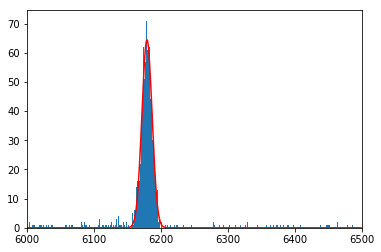

In [33]:

print(FWHM(yhist,6000,6500))